# Research Notebook 

## The goal

The goal here is to understand the impact that data gaps have on the L01 pipeline. As seen, the impact of gaps on the telemetry variables result in a widening of the data gaps in the overall Michelson-like variables. I want to try and understand 

* What type of data gap is most impacted
* What generation of TDI is most impactful
* What do the data gap widening depend on? 
* Can I build a distribution of data gaps?

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
data_direc = "../data_for_simulations"
from lisaglitch import GapMaskGenerator

sys.path.append("../../utility_funcs")  # if gap_widening_utils.py is in the parent directory
from gap_widening_utils import (
    construct_mask_single_gap,
    gap_augmentation_expression,
    widening_gap_X1,
    widening_gap_X2
)


# Set up the instrument simulator

In [2]:
from lisaconstants import au, SPEED_OF_LIGHT
from lisaorbits import StaticConstellation

### average light travel time ##
armlength = 2.5E9  # considering the standard value for the entire mission duration 

barycenter = [au, 0, 0] # m
orbits = StaticConstellation.from_armlengths(
    armlength, armlength, armlength, barycenter)

orbits.write("static_orbits.h5", mode = 'w')

In [3]:
#### --------  Note that you can also set up in this way ---------- ### 

#    MOSAS = ['12', '23', '31', '13', '32', '21']
#    armlength = 2.54E9/SPEED_OF_LIGHT
#    orbits = {mosa: armlength for mosa in MOSAS}
#    instr = Instrument(size=simlen, dt = 0.25, lock='six', seed=1234, orbits=orbits)
#    instr.disable_all_noises() 
#    instr.simulate()

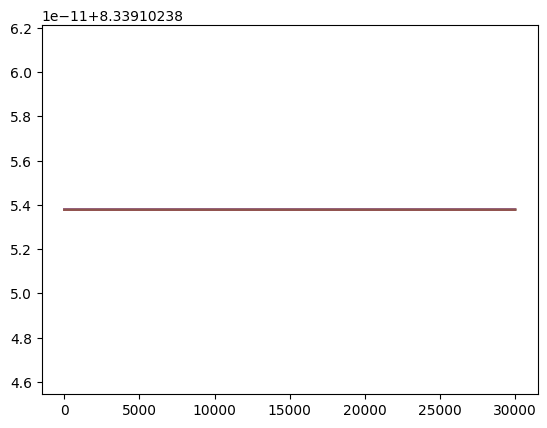

In [3]:
# Checking that the light travel times are constant. 

t = np.arange(0, 120_000*0.25,0.25)
for j in range(6):
    plt.plot(t, orbits.compute_ltt(t)[:,j], label=f"arm {j+1}")

In [4]:
# Set up lolipops pipeline
from pathlib import Path
from lisainstrument import Instrument
import logging

simlen = 20_000

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger('lisainstrument').setLevel(logging.INFO)

# Set up LISA instrument with static orbits
instr_static = Instrument(size=simlen, dt = 0.25, orbits = 'static_orbits.h5', seed=1234)

# Only incorporate laser noise, secondary noises: test-mass noise and OMS noise
instr_static.disable_all_noises(excluding=['laser', 'test-mass', 'oms']) 

# Simulate the LISA data
instr_static.simulate()

# Write to file
instr_static.write('static_short_simulation.h5', mode='w')

2025-12-18 10:55:13,834 - INFO - Initializing instrumental simulation
2025-12-18 10:55:13,836 - INFO - Computing measurement time vector (size=20000, dt=0.25)
2025-12-18 10:55:13,837 - INFO - Computing physics time vector (size=80000, dt=0.0625)
2025-12-18 10:55:13,838 - INFO - Computing telemetry time vector (size=2, dt=86400.0)
2025-12-18 10:55:13,843 - INFO - Using orbit file 'static_orbits.h5'
2025-12-18 10:55:14,275 - INFO - Using pre-defined locking configuration 'N1-12'
2025-12-18 10:55:14,276 - WARNING - Using default set of locking beatnote frequencies; this might cause interferometric beatnote frequencies to fall outside the requirement range of 5..25 MHz
2025-12-18 10:55:14,276 - INFO - Designing antialiasing filter ('kaiser', 240, 1.1, 2.9)
2025-12-18 10:55:14,276 - INFO - Starting simulation
2025-12-18 10:55:14,277 - INFO - Generating clock noise
2025-12-18 10:55:14,303 - INFO - Generating modulation noise
2025-12-18 10:55:14,303 - INFO - Generating backlink noise
2025-12-

In [5]:
from pytdi import Data

# Extract the data
data = Data.from_instrument(instr_static)

2025-12-18 10:55:18,909 - INFO - Loading instrument object '<lisainstrument.instrument.Instrument object at 0x10c147a70>'
2025-12-18 10:55:18,910 - WARNING - You are using LISA Instrument in a version that might not be fully supported
2025-12-18 10:55:18,910 - INFO - Initializing data object
2025-12-18 10:55:18,910 - INFO - Computing delay derivatives


# Widening of the gap due to delays
## The $\eta$ variables

Now in the next cell we are going to verify our formula for the widening of the eta variables

In [6]:
measurement_values = data.MEASUREMENTS # Extract the interferometer key values. 18 IFO values and sidebands
ifos = data.measurements # Extract the time-series measurements

mprs = data.delays # Extract measured pseudo ranges (estimated light travel times)
mpr_derivatives = data.delay_derivatives # Compute the derivatives of the measured pseudo ranges

# Extract MOSA labels
MOSAS = data.MOSAS
dt = 1/data.fs

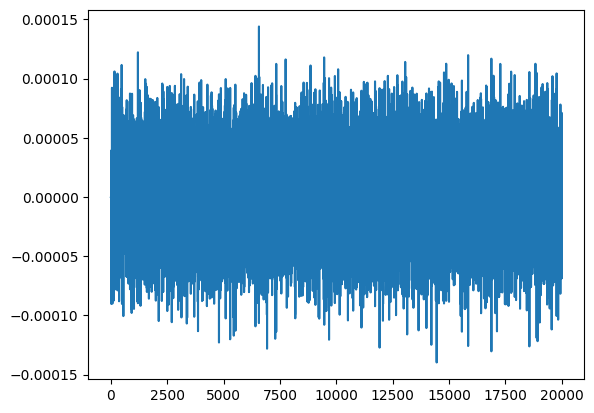

In [7]:
plt.plot(ifos['tmi_12'])

In [8]:
# I want to trim the mprs values by 1000 points at the start and end. 
# Slight issues with the end-points of interpolation schemes. 
N = 1000
mprs_trimmed = {}
for item in list(mprs.keys()):
    mprs_trimmed[item] = mprs[item][1000:-1000]

In [9]:
def nanify_telemetry_variables(data, masking_function):
    """
    Apply a masking function (with NaNs) to telemetry variables, pseudo-ranges, and their derivatives.

    Args:
        data (object): Telemetry object with .ifos attribute (dict-like).
        masking_function (np.ndarray): Array of 1s and NaNs to apply as a mask.

    Returns:
        tuple: (telemetry_w_gaps, mprs_w_nans, mpr_derivatives_w_nans)
            telemetry_w_gaps: telemetry object with masked .ifos fields
            mprs_w_nans: dict of masked pseudo-ranges
            mpr_derivatives_w_nans: dict of masked pseudo-range derivatives
        telemetry (object): Telemetry object with .ifos attribute (dict-like).
        mprs (dict): Dictionary of pseudo-range arrays, keyed by MOSA.
        mpr_derivatives (dict): Dictionary of pseudo-range derivative arrays, keyed by MOSA.
        masking_function (np.ndarray): Array of 1s and NaNs to apply as a mask.

    Returns:
        tuple: (telemetry_w_gaps, mprs_w_nans, mpr_derivatives_w_nans)
            telemetry_w_gaps: telemetry object with masked .ifos fields
            mprs_w_nans: dict of masked pseudo-ranges
            mpr_derivatives_w_nans: dict of masked pseudo-range derivatives
    """
    import copy

    # Deep copy to avoid modifying original data
    MOSAS = data.MOSAS
    data_w_gaps = copy.deepcopy(data)

    # Build label lists for all relevant telemetry fields
    tmi_label = [f"tmi_{mosa}" for mosa in MOSAS]
    ref_label = [f"ref_{mosa}" for mosa in MOSAS]
    ref_sb_label = [f"ref_sb_{mosa}" for mosa in MOSAS]
    sci_label = [f"sci_{mosa}" for mosa in MOSAS]
    sci_sb_label = [f"sci_sb_{mosa}" for mosa in MOSAS]
    # Apply mask to all telemetry fields
    for tmi_item, ref_item, ref_sb_item, sci_item, sci_sb_item in zip(
        tmi_label, ref_label, ref_sb_label, sci_label, sci_sb_label
    ):
        data_w_gaps.measurements[tmi_item] = data.measurements[tmi_item] * masking_function
        data_w_gaps.measurements[ref_item] = data.measurements[ref_item] * masking_function
        data_w_gaps.measurements[sci_item] = data.measurements[sci_item] * masking_function
        
        # No need to mask sidebands since clock noise is ignored
        # data_w_gaps.measurements[ref_sb_item] = data.measurements[ref_sb_item] * masking_function
        # data_w_gaps.measurements[sci_sb_item] = data.measurements[sci_sb_item] * masking_function

    # Deep copy and mask pseudo-ranges and their derivatives
    # Also no need to mask mprs and derivatives since orbits are equal and non-evolving. 
    # for delay_craft in list(data.delays.keys()):
    #     data_w_gaps.delays[delay_craft] = masking_function * data.delays[delay_craft]
    #     data_w_gaps.delay_derivatives[delay_craft] = masking_function * data.delay_derivatives[delay_craft]

    return data_w_gaps 

Lost out on approximately 0.0013888888888888887 hours of data
This ammounts to 20 number of samples


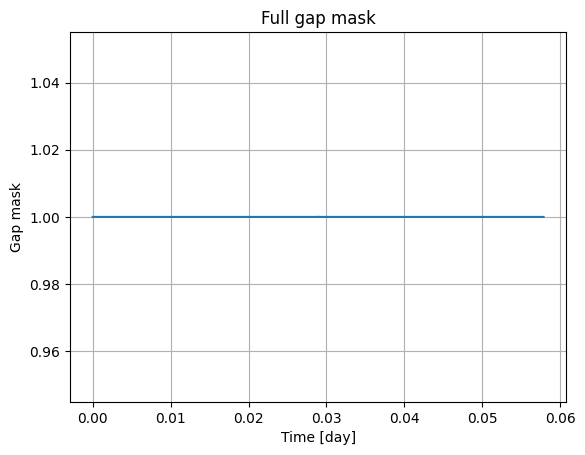

In [10]:
# Construct gap class

CONTROL_NANS = True
GAP_CLASS = False

sim_t = np.arange(0, simlen * dt, dt)


N_tel_nans= 20

masking_function = construct_mask_single_gap(N_tel_nans, length = simlen)


plt.plot(sim_t / 60 / 60 / 24, masking_function)
plt.title("Full gap mask")
plt.xlabel("Time [day]")
plt.ylabel("Gap mask")
plt.grid(True)

print(
    "Lost out on approximately",
    np.sum(np.isnan(masking_function)) * 0.25 / 60 / 60,
    "hours of data",
)
print(
    "This ammounts to {} number of samples".format(np.sum(np.isnan(masking_function)))
)

In [11]:
from pytdi.intervar import compute_etas

N_nans = 2000
order = 27
masking_function = construct_mask_single_gap(N_nans, length = simlen)
data_w_gaps = nanify_telemetry_variables(data, masking_function)
etas_w_gaps_nans = compute_etas(data_w_gaps, order, unit = "frequency")

N_nans_in_data = np.sum(np.isnan(data_w_gaps.measurements["tmi_12"]))
print("Number of nans in data", N_nans_in_data)
N_nans_in_eta_pytdi = np.sum(np.isnan(etas_w_gaps_nans["eta_12"]))
widening_gap_eta_pytdi = N_nans_in_eta_pytdi - N_nans
print("Number of nans in the eta variables = ", N_nans_in_eta_pytdi)
print("Overall widening of gap in eta variables = ", widening_gap_eta_pytdi)

2025-12-18 10:55:37,436 - INFO - Initializing combination with components '{'sci_12': [(1.0, [])], 'ref_12': [(0.5, [])], 'ref_21': [(0.5, ['D_12'])], 'tmi_12': [(-0.5, [])], 'tmi_21': [(-0.5, ['D_12'])]}'
2025-12-18 10:55:37,436 - INFO - Rotating combination '<pytdi.core.LISATDICombination object at 0x11bdbef90>' by 120 degrees
2025-12-18 10:55:37,437 - INFO - Transforming combination '<pytdi.core.LISATDICombination object at 0x11bdbef90>' with mapping '{1: 2, 2: 3, 3: 1}'
2025-12-18 10:55:37,437 - INFO - Rotating combination '<pytdi.core.LISATDICombination object at 0x11b18ff80>' by 120 degrees
2025-12-18 10:55:37,437 - INFO - Transforming combination '<pytdi.core.LISATDICombination object at 0x11b18ff80>' with mapping '{1: 2, 2: 3, 3: 1}'
2025-12-18 10:55:37,438 - INFO - Reflecting combination '<pytdi.core.LISATDICombination object at 0x11bdbef90>' around '1'
2025-12-18 10:55:37,438 - INFO - Transforming combination '<pytdi.core.LISATDICombination object at 0x11bdbef90>' with mappin

2025-12-18 10:55:37,449 - INFO - Multiplying term '1.0 []' and '<pytdi.core.LISATDICombination object at 0x11c235e50>'
2025-12-18 10:55:37,449 - INFO - Simplifying combination '<pytdi.core.LISATDICombination object at 0x11c2477a0>'
2025-12-18 10:55:37,449 - INFO - Adding combinations '<pytdi.core.LISATDICombination object at 0x11bee8830>' and '<pytdi.core.LISATDICombination object at 0x11c2444d0>'
2025-12-18 10:55:37,449 - INFO - Simplifying combination '<pytdi.core.LISATDICombination object at 0x11c245f70>'
2025-12-18 10:55:37,450 - INFO - Simplifying combination '<pytdi.core.LISATDICombination object at 0x11bee99a0>'
2025-12-18 10:55:37,451 - INFO - Simplifying combination '<pytdi.core.LISATDICombination object at 0x11bee7e90>'
2025-12-18 10:55:37,451 - INFO - Simplifying combination '<pytdi.core.LISATDICombination object at 0x11bee6ab0>'
2025-12-18 10:55:37,452 - INFO - Simplifying combination '<pytdi.core.LISATDICombination object at 0x1186dc6b0>'
2025-12-18 10:55:37,452 - INFO - C

Number of nans in data 2000
Number of nans in the eta variables =  2047
Overall widening of gap in eta variables =  47


In [12]:
# Check formula with analytical computation:
# we can consider three type of delays:

# 1) constant delay equal to the average one which in this case is used to run the simulation

constant_delay1 = data_w_gaps.delays['d_12'][1000:][0]

# 2) constant delay equal to the maximum  value for the entire mission duration 

constant_delay2 = np.float64(2.54E9/SPEED_OF_LIGHT)

# 3)  constant delay equal to the minimum   value for the entire mission duration 

constant_delay3 = np.float64(2.45E9/SPEED_OF_LIGHT)

In [13]:
###  here we pick which value we want to use for the analytical computation

constant_delay = constant_delay1

In [14]:
########## -------------- ########


delay = constant_delay/dt # Here we take the mean LTT. 

widening_gap_eta_theory, N_nans_in_eta_theory = gap_augmentation_expression(order, N_nans, delay, delay_number=1.0)
print("Number of nans in the eta variables = ", N_nans_in_eta_theory)
print("Overall widening of gap in eta variables = ", widening_gap_eta_theory)

Number of nans in the eta variables =  2047
Overall widening of gap in eta variables =  47


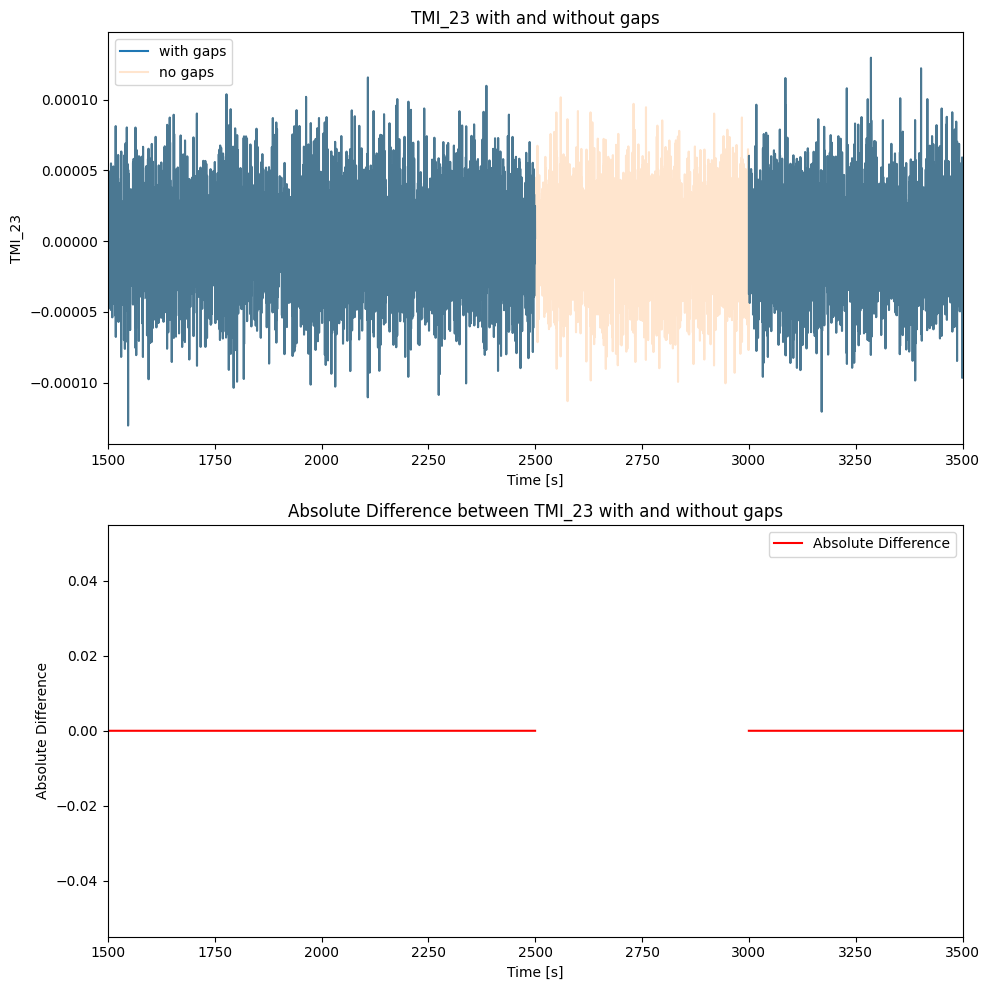

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

idx_start_gap = np.argwhere(np.isnan(masking_function) == True)[0][0]
idx_end_gap = np.argwhere(np.isnan(masking_function) == True)[-1][-1]
# First subplot: Original plot with gaps and no gaps
j = 1000
axs[0].plot(sim_t, data_w_gaps.measurements["tmi_23"], label="with gaps", alpha=1)
axs[0].plot(sim_t, data.measurements["tmi_23"], label="no gaps", alpha=0.2)
axs[0].set_xlim([sim_t[idx_start_gap] - j, sim_t[idx_start_gap] + j])
axs[0].set_ylabel(r"TMI_23")
# axs[0].set_ylim([-4100, -3200])
axs[0].set_xlabel("Time [s]")
axs[0].legend()
axs[0].set_title("TMI_23 with and without gaps")

# Second subplot: Absolute difference between the two
absolute_difference = np.abs(data_w_gaps.measurements["tmi_23"] - data.measurements["tmi_23"])
axs[1].plot(sim_t, absolute_difference, label="Absolute Difference", color="red")
axs[1].set_xlim([sim_t[idx_start_gap] - j, sim_t[idx_start_gap] + j])
axs[1].set_ylabel("Absolute Difference")
axs[1].set_xlabel("Time [s]")
axs[1].legend()
axs[1].set_title("Absolute Difference between TMI_23 with and without gaps")

plt.tight_layout()
plt.show()

In [16]:
order = 45
results_testing_N_nans = []
N_nans_in_telem_values = np.logspace(0, 2, num=50, dtype=int)  # Logarithmic spacing from 1 to 10000

for N_nans in tqdm(N_nans_in_telem_values):
    # Construct masking function
    masking_function = construct_mask_single_gap(N_nans, length=simlen)
        
    # Generate telemetry with gaps
    data_w_gaps = nanify_telemetry_variables(data, masking_function)

    # Compute eta variables with gaps
    etas_w_gaps_nans = compute_etas(data_w_gaps, order, unit="frequency")        
    # Calculate N_nans and widening for pytdi
    N_nans_in_eta_pytdi = np.sum(np.isnan(etas_w_gaps_nans["eta_12"]))
    widening_gap_eta_pytdi = N_nans_in_eta_pytdi - N_nans

    # Calculate N_nans and widening for theoretical model
    widening_gap_eta_theory, N_nans_in_eta_theory = gap_augmentation_expression(
        order, N_nans, delay, delay_number=1
    )
        
    # Append results to the list
    results_testing_N_nans.append({
        "N_nans": N_nans,
        "N_nans_in_eta_pytdi": N_nans_in_eta_pytdi,
        "N_nans_in_eta_theory": N_nans_in_eta_theory,
        "widening_gap_eta_pytdi": widening_gap_eta_pytdi,
        "widening_gap_eta_theory": widening_gap_eta_theory
    })
    

  0%|          | 0/50 [00:00<?, ?it/s]2025-12-18 10:55:46,432 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11c237380>'
2025-12-18 10:55:46,433 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x11c237380>'
2025-12-18 10:55:46,459 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11c1ad2b0>'
2025-12-18 10:55:46,460 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x11c1ad2b0>'
2025-12-18 10:55:46,485 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11c2465d0>'
2025-12-18 10:55:46,485 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x11c2465d0>'
2025-12-18 10:55:46,510 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11c247f20>'
2025-12-18 10:55:46,510 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x11c247f20>'
2025-12-18 10:55:46,527 - INFO - Building combination '<pytdi.core.LISATDICombinat

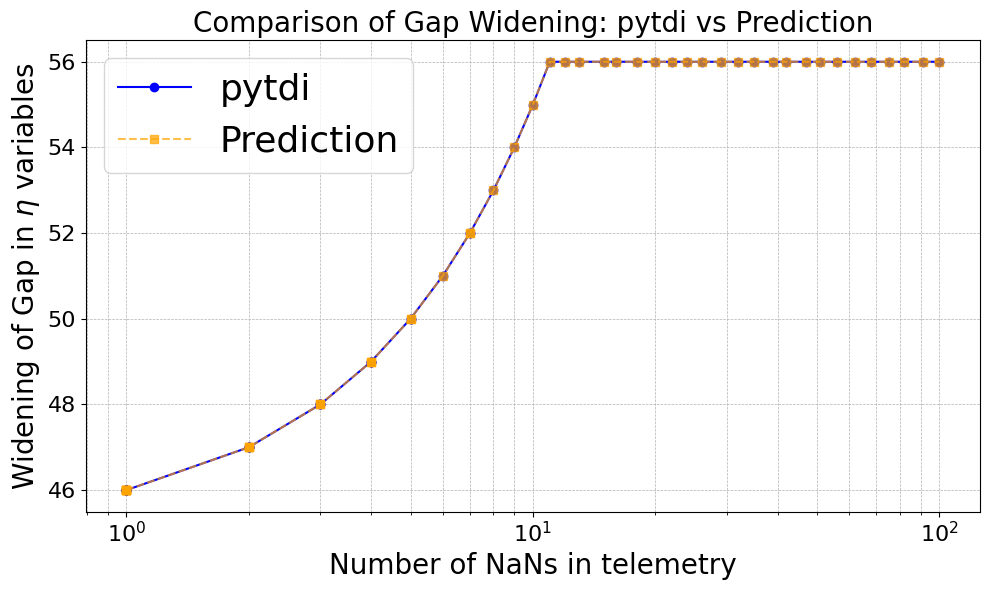

In [17]:
# Plot the results of the above cell

import matplotlib.pyplot as plt
import numpy as np

# Extract data from results
N_nans_in_telem_values = [result["N_nans"] for result in results_testing_N_nans]
widening_gap_eta_pytdi = [result["widening_gap_eta_pytdi"] for result in results_testing_N_nans]
widening_gap_eta_theory = [result["widening_gap_eta_theory"] for result in results_testing_N_nans]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(N_nans_in_telem_values, widening_gap_eta_pytdi, label="pytdi", marker="o", linestyle="-", color="blue")
plt.plot(N_nans_in_telem_values, widening_gap_eta_theory, label="Prediction", marker="s", linestyle="--", color="orange", alpha = 0.7)

# Add labels, legend, and grid
plt.xscale("log")
plt.xlabel("Number of NaNs in telemetry", fontsize=20)
plt.ylabel(r"Widening of Gap in $\eta$ variables", fontsize=20)
plt.title("Comparison of Gap Widening: pytdi vs Prediction", fontsize=20)
plt.legend(fontsize=26)

# Increase tick sizes
plt.tick_params(axis="both", which="major", labelsize=16)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Save and show the plot
plt.tight_layout()
plt.show()

# What do we learn here?
## For large strings of missing data, gap augmentation is constant. 



In [18]:
results_by_order = {}

# Define the gap configurations and range of orders
gap_configurations = [1, 10 , 100]
orders = range(25, 81,2)  # From 25 to 81 inclusive

# Loop over each gap configuration
for N_nans in gap_configurations:
    results_by_order[N_nans] = []  # Initialize results for this gap configuration
    
    # Construct masking function
    masking_function = construct_mask_single_gap(N_nans, length=simlen) 
    # Generate telemetry with gaps
    data_w_gaps = nanify_telemetry_variables(data, masking_function)
    for order in tqdm(orders):
        
        # Compute eta variables with gaps
        etas_w_gaps_nans = compute_etas(data_w_gaps, order, unit="frequency")        
        # Calculate N_nans and widening for pytdi
        N_nans_in_eta_pytdi = np.sum(np.isnan(etas_w_gaps_nans["eta_12"]))
        widening_gap_eta_pytdi = N_nans_in_eta_pytdi - N_nans

        # Calculate N_nans and widening for theoretical model
        widening_gap_eta_theory, N_nans_in_eta_theory = gap_augmentation_expression(
            order, N_nans, delay, delay_number=1
        )
        
        # Append results to the list for this gap configuration
        results_by_order[N_nans].append({
            "order": order,
            "N_nans_in_eta_pytdi": N_nans_in_eta_pytdi,
            "N_nans_in_eta_theory": N_nans_in_eta_theory,
            "widening_gap_eta_pytdi": widening_gap_eta_pytdi,
            "widening_gap_eta_theory": widening_gap_eta_theory
        })

  0%|          | 0/28 [00:00<?, ?it/s]2025-12-18 10:56:01,429 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11c237380>'
2025-12-18 10:56:01,430 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x11c237380>'
2025-12-18 10:56:01,442 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11c1ad2b0>'
2025-12-18 10:56:01,443 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x11c1ad2b0>'


2025-12-18 10:56:01,453 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11c2465d0>'
2025-12-18 10:56:01,454 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x11c2465d0>'
2025-12-18 10:56:01,465 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11c247f20>'
2025-12-18 10:56:01,466 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x11c247f20>'
2025-12-18 10:56:01,473 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11bee4920>'
2025-12-18 10:56:01,474 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x11bee4920>'
2025-12-18 10:56:01,481 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11bd36180>'
2025-12-18 10:56:01,481 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x11bd36180>'
2025-12-18 10:56:01,489 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11c237380>'
2025-12-18

<Figure size 640x480 with 0 Axes>

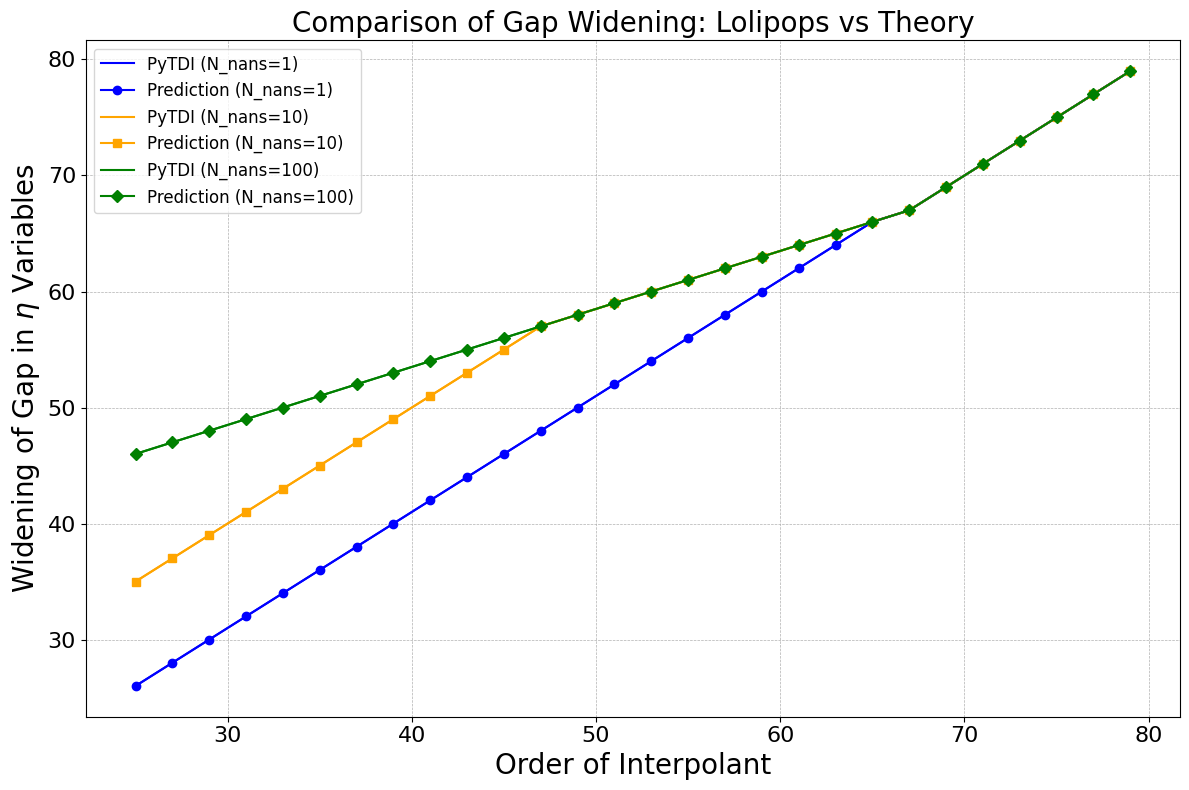

In [19]:
import matplotlib.pyplot as plt
plt.clf()
# Create a single plot for all gap configurations
plt.figure(figsize=(12, 8))

# Define markers and colors for each gap configuration
markers = ["o", "s", "D"]
colors = ["blue", "orange", "green"]

# Loop through each gap configuration and plot the results
for idx, (N_nans, results) in enumerate(results_by_order.items()):
    # Extract data for this N_nans configuration
    orders = [result["order"] for result in results]
    widening_gap_eta_pytdi = [result["widening_gap_eta_pytdi"] for result in results]
    widening_gap_eta_theory = [result["widening_gap_eta_theory"] for result in results]

    # Plot pytdi results (solid lines)
    plt.plot(
        orders, widening_gap_eta_pytdi,
        label=f"PyTDI (N_nans={N_nans})", 
        linestyle="-", color=colors[idx], zorder=1
    )
    
    # Plot theoretical results (dashed lines)
    plt.plot(
        orders, widening_gap_eta_theory, 
        label=f"Prediction (N_nans={N_nans})", 
        marker=markers[idx], color=colors[idx], zorder=2
    )

# Add labels, legend, and grid
plt.xlabel("Order of Interpolant", fontsize=20)
plt.ylabel(r"Widening of Gap in $\eta$ Variables", fontsize=20)
plt.title("Comparison of Gap Widening: Lolipops vs Theory", fontsize=20)
plt.legend(fontsize=12, loc="upper left")
plt.grid(True, linestyle="--", linewidth=0.5)

# Increase tick sizes
plt.tick_params(axis="both", which="major", labelsize=16)

# Save and show the plot
plt.tight_layout()
plt.show()

# Now let's try to do the same thing but with factorized TDI variables

We have no shown that the widening of the gap in the $\eta$ variables is sensitive to three things:

* The number of consecutive missing data in the telemetry variables
* The integer delay used when computing the interpolation
* The order of the interpolant. 

However, the quantity that L2A and L2D are most interested in are the L1 data products. In other words, the laser-cleaned TDI combinations $X$, $Y$ and $Z$ for various generations of TDI. Below we will do a similar analysis but now considering the TDI variables. 



In [20]:
from tqdm import tqdm as tqdm
from pytdi.michelson import compute_factorized_michelson
order = 45
results_TDI_testing_N_nans = []

N_nans_in_telem_values = np.logspace(0, 2, num=50, dtype=int)  # Logarithmic spacing from 1 to 10000

for N_nans in tqdm(N_nans_in_telem_values):
    # Construct masking function
    masking_function = construct_mask_single_gap(N_nans, length=simlen)
        
    # Generate telemetry with gaps
    data_w_gaps = nanify_telemetry_variables(
        data, masking_function
    )
        
    # Compute eta variables with gaps
    etas_w_gaps_nans = compute_etas(
        data_w_gaps, order = 45, unit = "frequency"
    )
    TDI_X = []
    for gen in range(1,3):
        # rot = 0 stands for TDI X variable 
        result = compute_factorized_michelson(
            data_w_gaps, etas = etas_w_gaps_nans, rot = 0, order = order, generation = gen
    )
        TDI_X.append(result)
        
    # Calculate N_nans and widening for lolipops
    N_nans_in_TDI = [np.sum(np.isnan(TDI_X[i])) for i in range(len(TDI_X))]
    N_nans_in_X1_pytdi = N_nans_in_TDI[0] 
    N_nans_in_X2_pytdi = N_nans_in_TDI[1] 

    widening_gap_X1_pytdi = N_nans_in_X1_pytdi - N_nans
    widening_gap_X2_pytdi = N_nans_in_X2_pytdi - N_nans
        
    # Calculate N_nans and widening for theoretical model
    _, N_nans_in_X1_theory = widening_gap_X1(order, N_nans, delay)
    _, N_nans_in_X2_theory = widening_gap_X2(order, N_nans, delay)

    widening_gap_X1_theory = N_nans_in_X1_theory - N_nans
    widening_gap_X2_theory = N_nans_in_X2_theory - N_nans
        
    # Append results to the list
    results_TDI_testing_N_nans.append({
        "N_nans": N_nans,
        "N_nans_in_X1_pytdi": N_nans_in_X1_pytdi,
        "N_nans_in_X2_pytdi": N_nans_in_X2_pytdi,
        "widening_gap_X1_pytdi": widening_gap_X1_pytdi,
        "widening_gap_X2_pytdi": widening_gap_X2_pytdi,
        "N_nans_in_X1_theory": N_nans_in_X1_theory,
        "N_nans_in_X2_theory": N_nans_in_X2_theory,
        "widening_gap_X1_theory": widening_gap_X1_theory,
        "widening_gap_X2_theory": widening_gap_X2_theory
    })
    

2025-12-18 10:56:21,382 - INFO - Initializing combination with components '{}'
2025-12-18 10:56:21,383 - INFO - Initializing combination with components '{'eta_21': [(1, ['A_12'])]}'
2025-12-18 10:56:21,383 - INFO - Multiplying term '1 []' and '<pytdi.core.LISATDICombination object at 0x11c93cb60>'
2025-12-18 10:56:21,383 - INFO - Simplifying combination '<pytdi.core.LISATDICombination object at 0x11c1acd10>'
2025-12-18 10:56:21,384 - INFO - Adding combinations '<pytdi.core.LISATDICombination object at 0x11bd37fb0>' and '<pytdi.core.LISATDICombination object at 0x11bdb9010>'
2025-12-18 10:56:21,384 - INFO - Simplifying combination '<pytdi.core.LISATDICombination object at 0x11c93eff0>'
2025-12-18 10:56:21,384 - INFO - Initializing combination with components '{'eta_12': [(1, ['A_21'])]}'
2025-12-18 10:56:21,384 - INFO - Multiplying term '1 ['A_12']' and '<pytdi.core.LISATDICombination object at 0x11bd37fb0>'
2025-12-18 10:56:21,384 - INFO - Simplifying combination '<pytdi.core.LISATDIC

2025-12-18 10:56:21,388 - INFO - Initializing combination with components '{'eta_12': [(1, [])]}'
2025-12-18 10:56:21,389 - INFO - Multiplying term '1 ['A_12', 'A_21', 'A_13', 'A_31']' and '<pytdi.core.LISATDICombination object at 0x11c936b70>'
2025-12-18 10:56:21,389 - INFO - Simplifying combination '<pytdi.core.LISATDICombination object at 0x11c8e6b10>'
2025-12-18 10:56:21,389 - INFO - Multiplying term '-1 []' and '<pytdi.core.LISATDICombination object at 0x11c8e6e70>'
2025-12-18 10:56:21,389 - INFO - Simplifying combination '<pytdi.core.LISATDICombination object at 0x11c8e6b10>'
2025-12-18 10:56:21,390 - INFO - Adding combinations '<pytdi.core.LISATDICombination object at 0x11c827d70>' and '<pytdi.core.LISATDICombination object at 0x11c8e5640>'
2025-12-18 10:56:21,390 - INFO - Simplifying combination '<pytdi.core.LISATDICombination object at 0x11c8e6a50>'
2025-12-18 10:56:21,390 - INFO - Initializing combination with components '{'eta_21': [(1, [])]}'
2025-12-18 10:56:21,390 - INFO 

# Plot the result

What we will show here is that the gap widening in the TDI variables is weakly dependent on the duration of the gap. We have a similar plot for the eta variables above. 

2025-12-18 10:57:49,199 - INFO - Substituting symbol K from STIXNonUnicode
2025-12-18 10:57:49,237 - INFO - Substituting symbol K from STIXNonUnicode
2025-12-18 10:57:49,293 - INFO - Substituting symbol K from STIXNonUnicode
2025-12-18 10:57:49,321 - INFO - Substituting symbol K from STIXNonUnicode


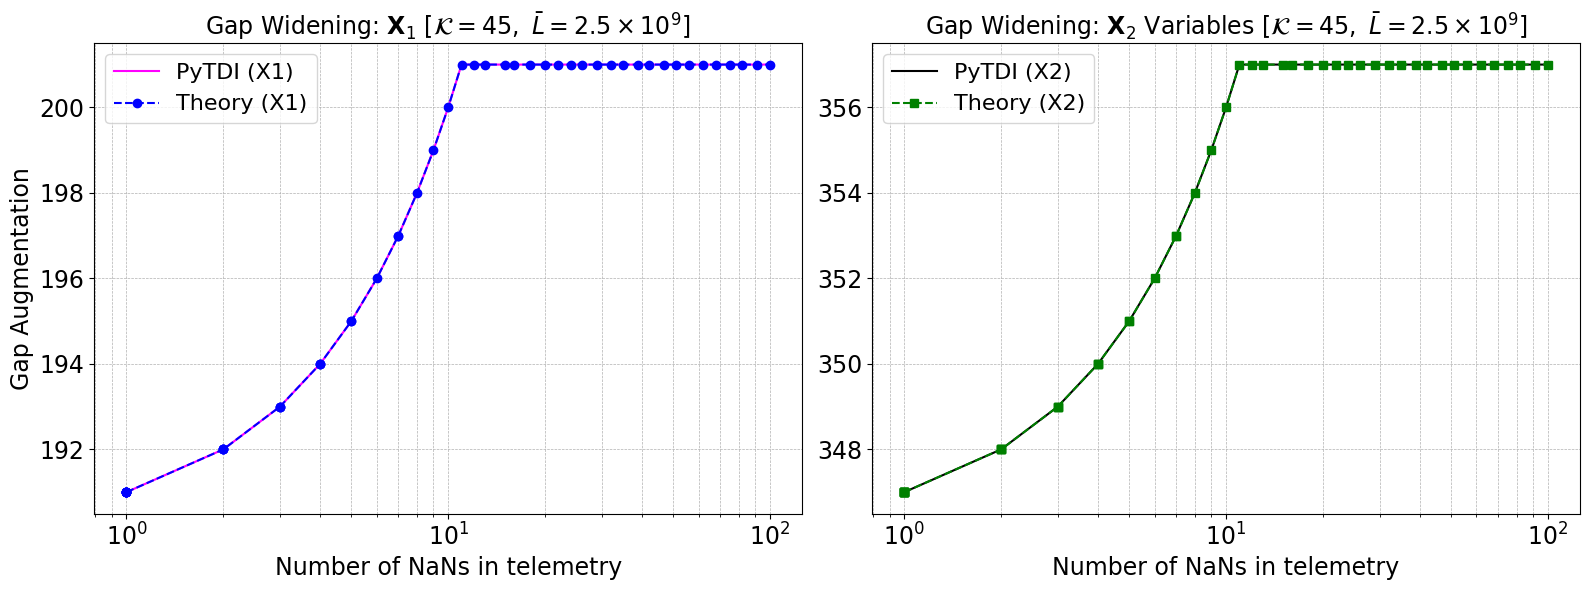

In [ ]:
import matplotlib.pyplot as plt

# Extract data from results
N_nans_values = [result["N_nans"] for result in results_TDI_testing_N_nans]
widening_gap_X1_pytdi = [result["widening_gap_X1_pytdi"] for result in results_TDI_testing_N_nans]
widening_gap_X2_pytdi = [result["widening_gap_X2_pytdi"] for result in results_TDI_testing_N_nans]
widening_gap_X1_theory = [result["widening_gap_X1_theory"] for result in results_TDI_testing_N_nans]
widening_gap_X2_theory = [result["widening_gap_X2_theory"] for result in results_TDI_testing_N_nans]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot X1 results on the left subplot
ax1.plot(
    N_nans_values, widening_gap_X1_pytdi, 
    label="PyTDI (X1)", linestyle="-", color="magenta"
)
ax1.plot(
    N_nans_values, widening_gap_X1_theory, 
    label="Theory (X1)", linestyle="--", marker="o", color="blue"
)
ax1.set_xscale("log")
ax1.set_xlabel("Number of NaNs in telemetry", fontsize=17)
ax1.set_ylabel("Gap Augmentation", fontsize=17)
ax1.set_title(
    r"Gap Widening: $\mathbf{X}_1$ [$\mathcal{K}= 45, \ \bar{L} = 2.5\times 10^{9}$]",
    fontsize=17
)
ax1.legend(fontsize=16, loc="upper left")
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.tick_params(axis="both", which="major", labelsize=17)

# Plot X2 results on the right subplot
ax2.plot(
    N_nans_values, widening_gap_X2_pytdi, 
    label="PyTDI (X2)", linestyle="-", color="black"
)
ax2.plot(
    N_nans_values, widening_gap_X2_theory, 
    label="Theory (X2)", linestyle="--", marker="s", color="green"
)
ax2.set_xscale("log")
ax2.set_xlabel("Number of NaNs in telemetry", fontsize=17)
# ax2.set_ylabel("Widening of Gap in X2 Variables", fontsize=14)
ax2.set_title(
    r"Gap Widening: $\mathbf{X}_2$ Variables [$\mathcal{K}= 45, \ \bar{L} = 2.5\times 10^{9}$]",
    fontsize=17
)
ax2.legend(fontsize=16, loc="upper left")
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
ax2.tick_params(axis="both", which="major", labelsize=17)

# Adjust layout and show the plot
plt.tight_layout()
# plt.savefig("../../Plots/gap_widening_comparison_TDI_subplots_seconds.pdf", dpi=300)  # Save as a high-resolution image
plt.show()

2025-12-18 11:04:56,629 - INFO - Substituting symbol K from STIXNonUnicode
2025-12-18 11:04:56,666 - INFO - Substituting symbol K from STIXNonUnicode
2025-12-18 11:04:56,680 - INFO - Substituting symbol K from STIXNonUnicode
2025-12-18 11:04:56,701 - INFO - Substituting symbol K from STIXNonUnicode
2025-12-18 11:04:56,721 - INFO - Substituting symbol K from STIXNonUnicode
2025-12-18 11:04:56,750 - INFO - Substituting symbol K from STIXNonUnicode
2025-12-18 11:04:56,875 - INFO - Substituting symbol K from STIXNonUnicode
2025-12-18 11:04:56,900 - INFO - Substituting symbol K from STIXNonUnicode


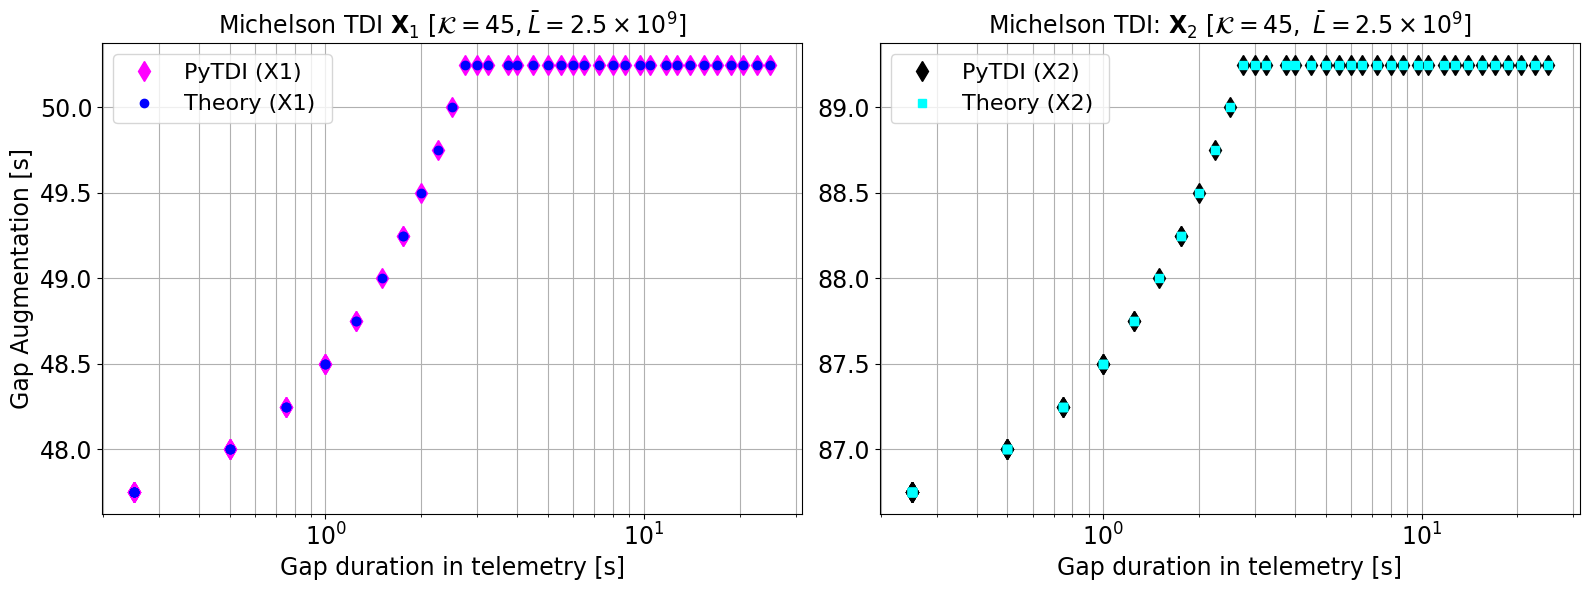

In [42]:
# Plot the results in seconds
import matplotlib.pyplot as plt

# Extract data from results
N_nans_values = [dt*result["N_nans"] for result in results_TDI_testing_N_nans]
widening_gap_X1_pytdi = [dt*result["widening_gap_X1_pytdi"] for result in results_TDI_testing_N_nans]
widening_gap_X2_pytdi = [dt*result["widening_gap_X2_pytdi"] for result in results_TDI_testing_N_nans]
widening_gap_X1_theory = [dt*(result["widening_gap_X1_theory"]) for result in results_TDI_testing_N_nans]
widening_gap_X2_theory = [dt*(result["widening_gap_X2_theory"]) for result in results_TDI_testing_N_nans]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot X1 results on the left subplot
ax1.plot(
    N_nans_values, widening_gap_X1_pytdi, 
    label="PyTDI (X1)",  marker = "d", linestyle = "", color="magenta", ms = 10.0
)
ax1.plot(
    N_nans_values, widening_gap_X1_theory, 
    label="Theory (X1) ", marker="o", linestyle = "", color="blue"
)
ax1.set_xscale("log")
ax1.set_xlabel("Gap duration in telemetry [s]", fontsize=17)
ax1.set_ylabel("Gap Augmentation [s]", fontsize=17)
ax1.set_title(r"Michelson TDI $\mathbf{X}_1$ [$\mathcal{K} = 45, \bar{L} = 2.5\times 10^{9}$]", fontsize=17)
ax1.legend(fontsize=16, loc="upper left")
ax1.grid(True, which="both")
ax1.tick_params(axis="both", which="major", labelsize=17)

# Plot X2 results on the right subplot
ax2.plot(
    N_nans_values, widening_gap_X2_pytdi, 
    label="PyTDI (X2) ", linestyle = "", marker = "d", color="black", ms = 10.0
)
ax2.plot(
    N_nans_values, widening_gap_X2_theory, 
    label="Theory (X2) ", linestyle = "", marker="s", color="cyan"
)
ax2.set_xscale("log")
ax2.set_xlabel("Gap duration in telemetry [s]", fontsize=17)
# ax2.set_ylabel("Widening of Gap in X2 Variables", fontsize=14)
ax2.set_title(r"Michelson TDI: $\mathbf{X}_2$ [$\mathcal{K}= 45, \ \bar{L} = 2.5\times 10^{9}$]", fontsize = 17)
ax2.legend(fontsize=16, loc="upper left")
ax2.grid(True, which="both")
ax2.tick_params(axis="both", which="major", labelsize=17)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("../../Plots/gap_widening_comparison_TDI_subplots_seconds_no_lines.pdf", dpi=300)  # Save as a high-resolution image
plt.show()

In [23]:
TDI_results_by_order = {}

# Define the gap configurations and range of orders
gap_configurations = [1, 10, 25]
orders = range(25, 81, 2)  # From 25 to 81 inclusive

# Loop over each gap configuration
for N_nans in gap_configurations:
    TDI_results_by_order[N_nans] = []  # Initialize results for this gap configuration
    # Construct masking function
    masking_function = construct_mask_single_gap(N_nans, length=simlen)
    
    for order in tqdm(orders):
        
        # Generate telemetry with gaps
        data_w_gaps = nanify_telemetry_variables(
            data, masking_function
        )
        
        # Compute eta variables with gaps
        etas_w_gaps_nans = compute_etas(
            data_w_gaps, order, unit="frequency"
        )        
        # Compute TDI variables for two generations
        TDI_X = []
        for gen in range(1, 3):
            result = compute_factorized_michelson(
                data_w_gaps, etas=etas_w_gaps_nans, rot=0, order=order, generation=gen
            )
            TDI_X.append(result)
        
        # Calculate N_nans and widening for pytdi
        N_nans_in_TDI = [np.sum(np.isnan(TDI_X[i])) for i in range(len(TDI_X))]
        widening_gap_X1_pytdi = N_nans_in_TDI[0] - N_nans
        widening_gap_X2_pytdi = N_nans_in_TDI[1] - N_nans

        # Calculate N_nans and widening for theoretical model
        _, N_nans_in_X1_theory = widening_gap_X1(order, N_nans, delay)
        _, N_nans_in_X2_theory = widening_gap_X2(order, N_nans, delay)
        widening_gap_X1_theory = N_nans_in_X1_theory - N_nans
        widening_gap_X2_theory = N_nans_in_X2_theory - N_nans
        
        # Append results to the list for this gap configuration
        TDI_results_by_order[N_nans].append({
            "order": order,
            "widening_gap_X1_pytdi": widening_gap_X1_pytdi,
            "widening_gap_X2_pytdi": widening_gap_X2_pytdi,
            "widening_gap_X1_theory": widening_gap_X1_theory,
            "widening_gap_X2_theory": widening_gap_X2_theory,
        })

  0%|          | 0/28 [00:00<?, ?it/s]2025-12-18 10:56:51,731 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11c237380>'
2025-12-18 10:56:51,731 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x11c237380>'
2025-12-18 10:56:51,742 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11c1ad2b0>'
2025-12-18 10:56:51,742 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x11c1ad2b0>'
2025-12-18 10:56:51,753 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11c2465d0>'
2025-12-18 10:56:51,753 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x11c2465d0>'
2025-12-18 10:56:51,764 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x11c247f20>'
2025-12-18 10:56:51,764 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x11c247f20>'
2025-12-18 10:56:51,771 - INFO - Building combination '<pytdi.core.LISATDICombinat

<Figure size 640x480 with 0 Axes>

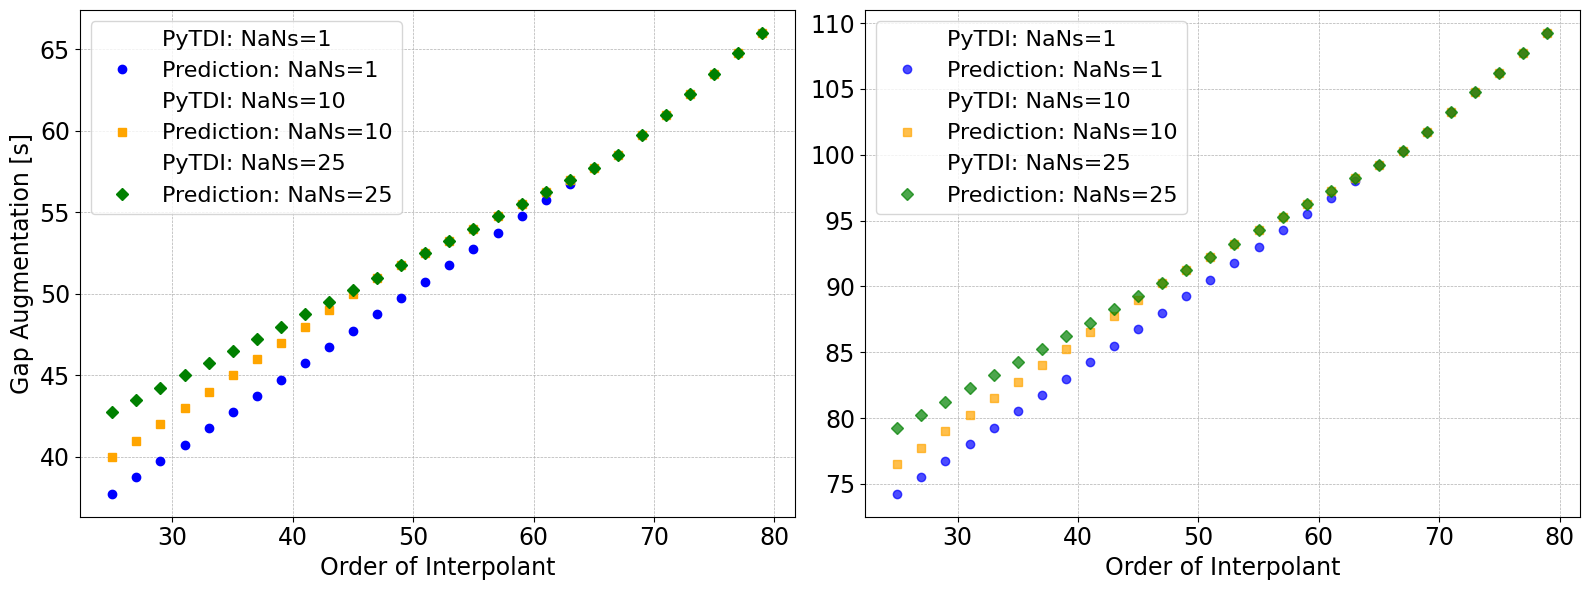

In [44]:
import matplotlib.pyplot as plt
plt.clf()

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define markers and colors for each gap configuration
markers = ["o", "s", "D"]
colors = ["blue", "orange", "green"]

# Loop through each gap configuration and plot the results for X1
for idx, (N_nans, results) in enumerate(TDI_results_by_order.items()):
    # Extract data for this N_nans configuration
    orders = [result["order"] for result in results]
    widening_gap_X1_pytdi = [dt*result["widening_gap_X1_pytdi"] for result in results]
    widening_gap_X1_theory = [dt*(result["widening_gap_X1_theory"]) for result in results]

    # Plot X1 results on the left subplot
    ax1.plot(
        orders, widening_gap_X1_pytdi, 
        label=f"PyTDI: NaNs={N_nans}", 
        linestyle="", color=colors[idx], zorder=1
    )
    ax1.plot(
        orders, widening_gap_X1_theory, 
        label=f"Prediction: NaNs={N_nans}", 
        marker=markers[idx], linestyle="", color=colors[idx], zorder=2
    )

# Customize the left subplot (X1)
ax1.set_xlabel("Order of Interpolant", fontsize=17)
ax1.set_ylabel(r"Gap Augmentation [s]", fontsize=17)
# ax1.set_title(r"Gap Widening: $X_1$ Variables", fontsize=20)
ax1.legend(fontsize=16, loc="upper left")
ax1.grid(True, linestyle="--", linewidth=0.5)
ax1.tick_params(axis="both", which="major", labelsize=17)

# Loop through each gap configuration and plot the results for X2
for idx, (N_nans, results) in enumerate(TDI_results_by_order.items()):
    # Extract data for this N_nans configuration
    orders = [result["order"] for result in results]
    widening_gap_X2_pytdi = [dt*result["widening_gap_X2_pytdi"] for result in results]
    widening_gap_X2_theory = [dt*(result["widening_gap_X2_theory"]) for result in results]

    # Plot X2 results on the right subplot
    ax2.plot(
        orders, widening_gap_X2_pytdi, 
        label=f"PyTDI: NaNs={N_nans}", 
        linestyle="", color=colors[idx], zorder=1, alpha=0.7
    )
    ax2.plot(
        orders, widening_gap_X2_theory, 
        label=f"Prediction: NaNs={N_nans}", 
        marker=markers[idx], linestyle="", color=colors[idx], zorder=2, alpha=0.7
    )

# Customize the right subplot (X2)
ax2.set_xlabel("Order of Interpolant", fontsize=17)
# ax2.set_title(r"Gap Widening: $X_2$ Variables", fontsize=20)
ax2.legend(fontsize=16, loc="upper left")
ax2.grid(True, linestyle="--", linewidth=0.5)
ax2.tick_params(axis="both", which="major", labelsize=17)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("../../Plots/gap_widening_comparison_TDI_change_interpolant_no_lines.pdf", dpi=300)  # Save as a high-resolution image
plt.show()

# The formulas check out

The formulas work extremely well for standard orders of interpolants $\mathcal{O}(L) \gtrsim 25$ providing that the missing data is contiguous. In other words, the \texttt{nans} are next to eachother. The formula *will* break down if you have multiple gaps that are very close to eachother. This is because as the nans propagate through the pipeline, the gated segments will start eating onto eachother. This means that the formula, predicting the total number of lost data will always over-estimate the loss, rather than underestimate it. This is good, we are being conservative. 

## The future goals

We will have multiple gaps of various durations. The question is how accurately (and quickly) can I predict the overall gap augmentation due to the TDI pipeline? Now I will use a generic masking function to do this. 

In [29]:
# Import the necessary functions from the multi_gap_utils module
# Assuming the functions are defined in a file named multi_gap_utils.py in the same directory
sys.path.append("../../")  # if multi_gap_utils.py is in the parent directory
from utility_funcs.multi_gap_utils import (
    mask_eta, 
    mask_TDI_X,
    approx_total_nans_from_nan_blocks_eta,
    approx_total_nans_from_nan_blocks_X
)

In [30]:
# Consider now a longer simulation for 3 days. Now going to look at multiple gaps.

simlen_multi_gap = 1_050_000

instr_3_days_static = Instrument(size=simlen_multi_gap, dt = 0.25, orbits = 'static_orbits.h5', seed=1234)

instr_3_days_static.disable_all_noises(excluding=['laser', 'test-mass', 'oms']) 
instr_3_days_static.simulate()

instr_3_days_static.write('static_3_day_simulation.h5', mode='w')

2025-09-16 23:08:20,902 - INFO - Initializing instrumental simulation
2025-09-16 23:08:20,906 - INFO - Computing measurement time vector (size=1050000, dt=0.25)
2025-09-16 23:08:20,908 - INFO - Computing physics time vector (size=4200000, dt=0.0625)


2025-09-16 23:08:20,917 - INFO - Computing telemetry time vector (size=5, dt=86400.0)
2025-09-16 23:08:20,932 - INFO - Using orbit file 'static_orbits.h5'
2025-09-16 23:08:23,444 - INFO - Using pre-defined locking configuration 'N1-12'
2025-09-16 23:08:23,444 - WARNING - Using default set of locking beatnote frequencies; this might cause interferometric beatnote frequencies to fall outside the requirement range of 5..25 MHz
2025-09-16 23:08:23,444 - INFO - Designing antialiasing filter ('kaiser', 240, 1.1, 2.9)
2025-09-16 23:08:23,445 - INFO - Starting simulation
2025-09-16 23:08:23,445 - INFO - Generating clock noise
2025-09-16 23:08:23,519 - INFO - Generating modulation noise
2025-09-16 23:08:23,519 - INFO - Generating backlink noise
2025-09-16 23:08:23,520 - INFO - Generating test-mass acceleration noise
2025-09-16 23:08:25,150 - INFO - Generating ranging noise
2025-09-16 23:08:25,150 - INFO - Generating OMS noise
2025-09-16 23:08:30,219 - INFO - Generating DWS measurement noise
202

In [31]:
data_3_day_sim = Data.from_instrument(instr_3_days_static)

2025-09-16 23:09:57,981 - INFO - Loading instrument object '<lisainstrument.instrument.Instrument object at 0x131928aa0>'
2025-09-16 23:09:57,983 - WARNING - You are using LISA Instrument in a version that might not be fully supported
2025-09-16 23:09:57,983 - INFO - Initializing data object
2025-09-16 23:09:57,984 - INFO - Computing delay derivatives


# Define the overall masking function

The masking function will take in a dictionary of gating functions

In [43]:
# Generate the mask with sampling interval 0.25 seconds

# Define the gap function 

# Construct gap class

sim_t = np.arange(0, simlen_multi_gap * dt, dt)

gap_definitions = {
    "planned": {
        # "Instrumental Maintainance": {"rate_per_year": 5 * 260, "duration_hr": 0.01*3.3}
        "Instrumental Maintainance": {"rate_per_year": 10 * 260, "duration_hr": 0.01*3.3}
    },
    "unplanned": {
        "Instrument breaks": {"rate_per_year": 3, "duration_hr": 60},
    }
}

# Initialise class with rates, and sampling properties.
generator_gap_3_day = GapMaskGenerator(
    sim_t,
    gap_definitions,
    treat_as_nan=True,
    planseed=11_07_1993,
    unplanseed=16_12_1997
)

# Generate the mask full of gaps
full_mask_3_day = generator_gap_3_day.generate_mask(include_unplanned=False, include_planned=True)
N_nans_check = np.sum(np.isnan(full_mask_3_day))

extract_summary = generator_gap_3_day.summary(mask = full_mask_3_day)
from pprint import pprint
pprint(extract_summary['mask_analysis'])

{'duty_cycle_percent': np.float64(99.05),
 'number_of_gap_segments': 21,
 'total_gap_hours': np.float64(0.69),
 'total_gap_samples': 9975}


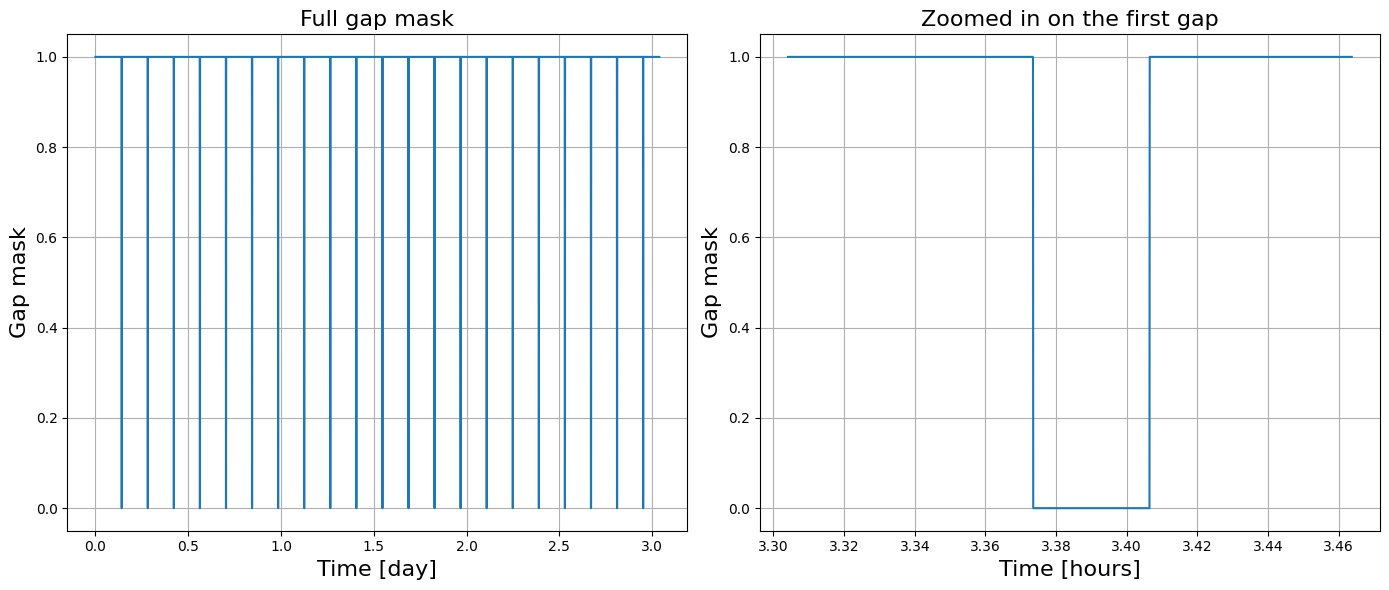

In [44]:
# Construct gap class

# This array is only used for plotting to show the presence of multiple gaps
# and their duration

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot the full gap mask on the left subplot
full_mask_3_day_w_zeros = np.nan_to_num(full_mask_3_day, nan=0.0)
axs[0].plot(sim_t / 60 / 60 / 24, full_mask_3_day_w_zeros)
axs[0].set_title("Full gap mask", fontsize = 16)
axs[0].set_xlabel("Time [day]", fontsize = 16)
axs[0].set_ylabel("Gap mask", fontsize = 16)
axs[0].grid(True)

# Zoom in on the first gap on the right subplot
first_gap_start = np.where(np.isnan(full_mask_3_day))[0][0]
zoom_start = max(0, first_gap_start - 1000)  # Adjust to include some context
zoom_end = min(len(sim_t), first_gap_start + 1300)
axs[1].plot(sim_t[zoom_start:zoom_end] / 60 / 60 , full_mask_3_day_w_zeros[zoom_start:zoom_end])
axs[1].set_title("Zoomed in on the first gap", fontsize = 16)
axs[1].set_xlabel("Time [hours]", fontsize = 16)
axs[1].set_ylabel("Gap mask", fontsize = 16)
axs[1].grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [45]:
# Let's compute the true number of nans in the eta variables
N_nans_multiple_gaps = np.sum(np.isnan(full_mask_3_day))

data_w_multi_gaps = nanify_telemetry_variables(data_3_day_sim, full_mask_3_day)
etas_w_multi_gaps = compute_etas(
    data_w_multi_gaps, order=order, unit="frequency"
)

# LTT = data_w_multi_gaps.delays['d_12'][1000:][0]  # Take the mean LTT
# delay_integer_fraction = LTT / dt  # Here we take the mean LTT. "samples"
eta_mask = mask_eta(full_mask_3_day, delay=delay, order=order)

print("")
print("Doing things using pytdi")
N_nans_in_eta_w_multi_gaps_pytdi = np.sum(np.isnan(etas_w_multi_gaps["eta_12"]))
widening_gap_eta_pytdi = N_nans_in_eta_w_multi_gaps_pytdi - N_nans_multiple_gaps
print("Number of nans in the eta variables = ", N_nans_in_eta_w_multi_gaps_pytdi)
print("Overall widening of gap in eta variables = ", widening_gap_eta_pytdi)
print("")

print("Now doing things carefully but using theory")
N_nans_in_eta_w_multi_gaps_theory = np.sum(np.isnan(eta_mask))
widening_gap_eta_theory = N_nans_in_eta_w_multi_gaps_theory - N_nans_multiple_gaps
print("Number of nans in the eta variables = ", N_nans_in_eta_w_multi_gaps_theory)
print("Overall widening of gap in eta variables = ", widening_gap_eta_theory)

# Can I try to approximate this result?
print("")
print("Now using our quick approximation formula")

# Quick approximation formula
approx_nans_in_eta = approx_total_nans_from_nan_blocks_eta(full_mask_3_day, delay, lagrange_order=order, delay_number=1.0)
approx_widening_gap_eta = approx_nans_in_eta - N_nans_multiple_gaps
print("Approx number of nans in the eta variables = ", approx_nans_in_eta)
print("Overall widening of gap in eta variables = ", approx_widening_gap_eta)



2025-09-16 23:12:00,121 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x131255130>'
2025-09-16 23:12:00,122 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x131255130>'
2025-09-16 23:12:01,260 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x127c75490>'
2025-09-16 23:12:01,262 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x127c75490>'
2025-09-16 23:12:02,430 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x131204b30>'
2025-09-16 23:12:02,432 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x131204b30>'
2025-09-16 23:12:03,539 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x127fe5fa0>'
2025-09-16 23:12:03,541 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x127fe5fa0>'
2025-09-16 23:12:04,326 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x131255f70>'
2025-09-16


Doing things using pytdi
Number of nans in the eta variables =  11151
Overall widening of gap in eta variables =  1176

Now doing things carefully but using theory
Number of nans in the eta variables =  11151
Overall widening of gap in eta variables =  1176

Now using our quick approximation formula
Approx number of nans in the eta variables =  11151
Overall widening of gap in eta variables =  1176


<!-- # Try to do the same thing but with TDI X variables for both generations -->

In [46]:

# Compute TDI variables for generation 1 and generation 2
order = 45
TDI_X = []
for gen in range(1, 3):
    result = compute_factorized_michelson(
    data_w_multi_gaps, etas = etas_w_multi_gaps, rot=0, order=order, generation=gen
    )
    TDI_X.append(result)


2025-09-16 23:12:10,142 - INFO - Initializing combination with components '{'eta_12': [(1, [])], 'eta_21': [(1, ['D_12'])]}'
2025-09-16 23:12:10,143 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x131928230>'
2025-09-16 23:12:10,145 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x131928230>'


2025-09-16 23:12:10,547 - INFO - Initializing combination with components '{'eta_13': [(1, [])], 'eta_31': [(1, ['D_13'])]}'
2025-09-16 23:12:10,548 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x1319298b0>'
2025-09-16 23:12:10,549 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x1319298b0>'
2025-09-16 23:12:10,922 - INFO - Initializing combination with components '{'x_arm_1': [(-1, []), (1, ['D_13', 'D_31'])], 'x_arm_2': [(1, []), (-1, ['D_12', 'D_21'])]}'
2025-09-16 23:12:10,922 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x131906180>'
2025-09-16 23:12:11,084 - INFO - Evaluate combination '<pytdi.core.LISATDICombination object at 0x131906180>'
2025-09-16 23:12:11,842 - INFO - Initializing combination with components '{'eta_12': [(1, [])], 'eta_21': [(1, ['D_12'])]}'
2025-09-16 23:12:11,842 - INFO - Building combination '<pytdi.core.LISATDICombination object at 0x16831a1e0>'
2025-09-16 23:12:11,844 - INFO 

In [47]:
# Compute mask for TDI X2 using formulas present in the paper (see appendix)
# Here we are doing things carefully, make sure to carefully compute the number
# of missing data point, even if gaps in the data streams begin to merge due to
# the delay operators. 

X2_mask = mask_TDI_X(full_mask_3_day, delay=delay, order=order, generation=2)

# Careful theoretical computation
N_nans_using_X2_mask = np.sum(np.isnan(X2_mask))

# Numerical treatment using pytdi
N_nans_using_pytdi_X2 = np.sum(np.isnan(TDI_X[1]))

# This is a very quick to compute formula to approximate the number of nans. Instead of 
# carefully computing the indices of each nan placement and widening them by an amount predicted in the paper, 
# we just use the piecewise function that predicts the gap augmentation over and over again. It's faster. 

check_N_nans_in_X2_theory = approx_total_nans_from_nan_blocks_X(full_mask_3_day, delay=delay, order=order, generation=2)

print("widening for TDI2 using pytdi ", N_nans_using_pytdi_X2 - N_nans_multiple_gaps)
print("widening for TDI2 using mask ", N_nans_using_X2_mask - N_nans_multiple_gaps)
print("widening for TDI2 using formulas ", check_N_nans_in_X2_theory - N_nans_multiple_gaps)

widening for TDI2 using pytdi  7497
widening for TDI2 using mask  7497
widening for TDI2 using formulas  7497


In [48]:

# Check the gap augmentation using pytdi -- numerical computation. This is our
# benchmark
print("Using pytdi")
N_nans_in_X1_w_multi_gaps_pytdi = np.sum(np.isnan(TDI_X[0]))
N_nans_in_X2_w_multi_gaps_pytdi = np.sum(np.isnan(TDI_X[1]))

widening_gap_X1_pytdi = N_nans_in_X1_w_multi_gaps_pytdi - N_nans_multiple_gaps
widening_gap_X2_pytdi = N_nans_in_X2_w_multi_gaps_pytdi - N_nans_multiple_gaps
print("pytdi: Number of nans in X1 variables = ", N_nans_in_X1_w_multi_gaps_pytdi)
print("pytdi: Widening of gap in X1 variables = ", widening_gap_X1_pytdi)
print("pytdi: Number of nans in X2 variables = ", N_nans_in_X2_w_multi_gaps_pytdi)
print("pytdi: Widening of gap in X2 variables = ", widening_gap_X2_pytdi)

print("")
print("Now doing things carefully but using theory")
print("")

# Compute the masking function for X1 and X2 variables using formulas
# This method is slow but accurate. Always returns the exact same number 
# of missing data as predicted via pytdi
X1_mask = mask_TDI_X(full_mask_3_day, delay, order=order, generation=1)
X2_mask = mask_TDI_X(full_mask_3_day, delay, order=order, generation=2)

N_nans_in_X1_w_multi_gaps_theory = np.sum(np.isnan(X1_mask))
N_nans_in_X2_w_multi_gaps_theory = np.sum(np.isnan(X2_mask))
widening_gap_X1_theory = N_nans_in_X1_w_multi_gaps_theory - N_nans_multiple_gaps
widening_gap_X2_theory = N_nans_in_X2_w_multi_gaps_theory - N_nans_multiple_gaps
print("Theory: Number of nans in X1 variables = ", N_nans_in_X1_w_multi_gaps_theory)
print("Theory: Widening of gap in X1 variables = ", widening_gap_X1_theory)
print("Theory: Number of nans in X2 variables = ", N_nans_in_X2_w_multi_gaps_theory)
print("Theory: Widening of gap in X2 variables = ", widening_gap_X2_theory)
print("")

# Now use approximate formula. This formula does not take into account merging of gaps if individual 
# gap placements are really close to eachother. So it is expected to be less accurate than the
# careful computation above. But it is very fast to compute.
print("Now using our quick approximation formula")
print("")

approx_nans_in_X1 = approx_total_nans_from_nan_blocks_X(full_mask_3_day, delay, order=order, generation=1)
approx_nans_in_X2 = approx_total_nans_from_nan_blocks_X(full_mask_3_day, delay, order=order, generation=2)

approx_widening_gap_X1 = approx_nans_in_X1 - N_nans_multiple_gaps
approx_widening_gap_X2 = approx_nans_in_X2 - N_nans_multiple_gaps
print("Approx: Number of nans in X1 variables = ", approx_nans_in_X1)
print("Approx:  Widening of gap in X1 variables = ", approx_widening_gap_X1)
print("Approx: Number of nans in X2 variables = ", approx_nans_in_X2)
print("Approx:  Widening of gap in X2 variables = ", approx_widening_gap_X2)

Using pytdi
pytdi: Number of nans in X1 variables =  14196
pytdi: Widening of gap in X1 variables =  4221
pytdi: Number of nans in X2 variables =  17472
pytdi: Widening of gap in X2 variables =  7497

Now doing things carefully but using theory

Theory: Number of nans in X1 variables =  14196
Theory: Widening of gap in X1 variables =  4221
Theory: Number of nans in X2 variables =  17472
Theory: Widening of gap in X2 variables =  7497

Now using our quick approximation formula

Approx: Number of nans in X1 variables =  14196
Approx:  Widening of gap in X1 variables =  4221
Approx: Number of nans in X2 variables =  17472
Approx:  Widening of gap in X2 variables =  7497


In [49]:
import timeit

# Define the parameters for the test
generation = 2  # Generation of TDI
order = 45  # Order of interpolant
delay = 2.5E9 / SPEED_OF_LIGHT  # Delay in seconds

# Measure the time for approx_total_nans_from_nan_blocks_X
approx_time = timeit.timeit(
    lambda: approx_total_nans_from_nan_blocks_X(full_mask_3_day, delay=delay, order=order, generation=generation),
    number=100  # Run the function 10 times for averaging
)

# Measure the time for np.sum(mask_TDI_X)
mask_time = timeit.timeit(
    lambda: np.sum(mask_TDI_X(full_mask_3_day, delay=delay, order=order, generation=generation)),
    number=100  # Run the function 10 times for averaging
)

# Print the results
print(f"Time taken by approx_total_nans_from_nan_blocks_X: {approx_time / 100:.6f} seconds (average over 100 runs)")
print(f"Time taken by np.sum(mask_TDI_X): {mask_time / 100:.6f} seconds (average over 100 runs)")
print(f"This is a gain in performance using the approx method of a factor {mask_time / approx_time:.2f}")

Time taken by approx_total_nans_from_nan_blocks_X: 0.000629 seconds (average over 100 runs)
Time taken by np.sum(mask_TDI_X): 0.007413 seconds (average over 100 runs)
This is a gain in performance using the approx method of a factor 11.79
